In [75]:
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os,sys

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras import optimizers
from keras.layers import BatchNormalization
from tensorflow.keras.metrics import MeanIoU
from keras import backend as K
import keras
import random
from sklearn.model_selection import train_test_split

from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from datetime import datetime

from mask_to_submission import masks_to_submission

In [76]:
## Install the following packages
import imageio
import cv2

## Constants

In [3]:
IMG_WIDTH = 608
IMG_HEIGHT = 608
EPOCHS = 100
LEARNING_RATE = 0.0001
BATCH_SIZE = 16
rnd_seed = 4

## Load Images

In [57]:
training_image_dir = "training_images/images/"
training_label_dir = "training_images/groundtruth/"
test_image_dir = "test_images/"

files_image = os.listdir(training_image_dir)
files_label = os.listdir(training_label_dir)
files_test = os.listdir(test_image_dir)
n = len(files_image)
n_test = len(files_test) 

# Load list of numpy arrays of training images and labels
print("Loading " + str(n) + " training images")
training_image_list = [imageio.imread(training_image_dir + files_image[i]) for i in range(n)]
training_label_list = [imageio.imread(training_label_dir + files_label[i]) for i in range(n)]

# Load list of numpy arrays of test images
print("Loading " + str(n_test) + " test images")
test_image_list = [imageio.imread(test_image_dir + files_test[i]) for i in range(n_test)]

print("TRAINING:")
print(training_image_list[0].shape)
print(training_label_list[0].shape)
print("TEST:")
print(test_image_list[0].shape)

Loading 100 training images
Loading 94 test images
TRAINING:
(400, 400, 3)
(400, 400)
TEST:
(608, 608, 3)


## Padd Images
Training images have size 400x400 and test images have size 608x608. So we need to pad training images to same size, 
for that I use mirror padding for now.

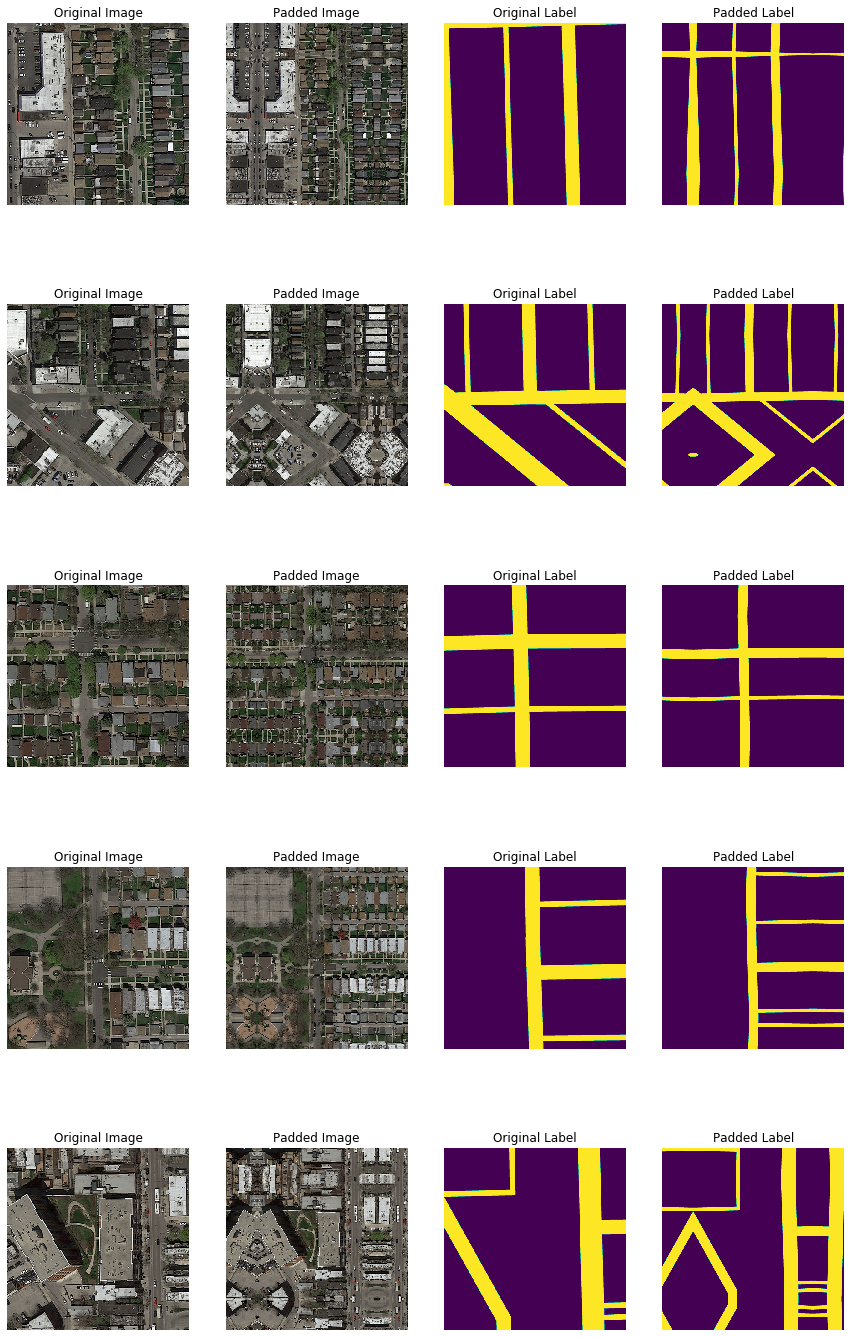

(100, 608, 608, 3)
(100, 608, 608, 1)


In [53]:
# Mirror padd all training images to get same size as test images
training_image_padded_list = [cv2.copyMakeBorder(training_image_list[i],104,104,104,104,cv2.BORDER_REFLECT) for i in range(n)]
training_label_padded_list = [cv2.copyMakeBorder(training_label_list[i],104,104,104,104,cv2.BORDER_REFLECT) for i in range(n)]

# Plot random Sample of images
index = random.randint(0, n-1)
num_samples = 5

f = plt.figure(figsize = (15, 25))
for i in range(1, num_samples*4, 4):
  index = random.randint(0, n-1)

  f.add_subplot(num_samples, 4, i)
  plt.imshow(training_image_list[index])
  plt.title("Original Image")
  plt.axis('off')

  f.add_subplot(num_samples, 4, i+1)
  plt.imshow(training_image_padded_list[index])
  plt.title("Padded Image")
  plt.axis('off')

  f.add_subplot(num_samples, 4, i+2)
  plt.imshow(np.squeeze(training_label_list[index]))
  plt.title("Original Label")
  plt.axis('off')

  f.add_subplot(num_samples, 4, i+3)
  plt.imshow(np.squeeze(training_label_padded_list[index]))
  plt.title("Padded Label")
  plt.axis('off')

plt.show()

# Convert image lists to numpy arrays for further processing
training_image = np.array(training_image_padded_list)
training_label = np.expand_dims(np.array(training_label_padded_list), -1)
test_image = np.array(test_image_list)
print(training_image.shape)
print(training_label.shape)

## Loss Function and Accuracy Metric
- Accuracy: Intersection of prediction to label image over Union
- Loss : Soft Dice Loss (Measure of interleaving of prediction image and label image)

Source: https://towardsdatascience.com/metrics-to-evaluate-your-semantic-segmentation-model-6bcb99

In [6]:
from keras import backend as K
def iou_coef(y_true, y_pred, smooth=1):
  intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
  union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
  iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
  
  return iou

In [7]:
def dice_coef(y_true, y_pred, smooth = 1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def soft_dice_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

## Model: Fully CNN built in Keras

In [8]:
inputs = Input((IMG_HEIGHT, IMG_WIDTH, 3))
#s = Lambda(lambda x: x / 400) (inputs)

conv1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (inputs)
conv1 = BatchNormalization() (conv1)
conv1 = Dropout(0.1) (conv1)
conv1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv1)
conv1 = BatchNormalization() (conv1)
pooling1 = MaxPooling2D((2, 2)) (conv1)

conv2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (pooling1)
conv2 = BatchNormalization() (conv2)
conv2 = Dropout(0.1) (conv2)
conv2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv2)
conv2 = BatchNormalization() (conv2)
pooling2 = MaxPooling2D((2, 2)) (conv2)

conv3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (pooling2)
conv3 = BatchNormalization() (conv3)
conv3 = Dropout(0.2) (conv3)
conv3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv3)
conv3 = BatchNormalization() (conv3)
pooling3 = MaxPooling2D((2, 2)) (conv3)

conv4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (pooling3)
conv4 = BatchNormalization() (conv4)
conv4 = Dropout(0.2) (conv4)
conv4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv4)
conv4 = BatchNormalization() (conv4)
pooling4 = MaxPooling2D(pool_size=(2, 2)) (conv4)

conv5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (pooling4)
conv5 = BatchNormalization() (conv5)
conv5 = Dropout(0.3) (conv5)
conv5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv5)
conv5 = BatchNormalization() (conv5)


upsample6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (conv5)
upsample6 = concatenate([upsample6, conv4])
conv6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (upsample6)
conv6 = BatchNormalization() (conv6)
conv6 = Dropout(0.2) (conv6)
conv6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv6)
conv6 = BatchNormalization() (conv6)

upsample7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (conv6)
upsample7 = concatenate([upsample7, conv3])
conv7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (upsample7)
conv7 = BatchNormalization() (conv7)
conv7 = Dropout(0.2) (conv7)
conv7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv7)
conv7 = BatchNormalization() (conv7)

upsample8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (conv7)
upsample8 = concatenate([upsample8, conv2])
conv8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (upsample8)
conv8 = BatchNormalization() (conv8)
conv8 = Dropout(0.1) (conv8)
conv8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv8)
conv8 = BatchNormalization() (conv8)

upsample9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (conv8)
upsample9 = concatenate([upsample9, conv1], axis=3)
conv9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (upsample9)
conv9 = BatchNormalization() (conv9)
conv9 = Dropout(0.1) (conv9)
conv9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv9)
conv9 = BatchNormalization() (conv9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (conv9)

model = Model(inputs=[inputs], outputs=[outputs])
model.summary()












Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 608, 608, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 608, 608, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 608, 608, 16) 64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 608, 608, 16) 0           batch_normaliza

## Callbacks for Observations

In [21]:
#tbc=TensorBoardColab()
model_path = "./Models/fullyCNN_temp.h5"
checkpointer = ModelCheckpoint(model_path,
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)
csv_logger = CSVLogger("./Logs/fullyCNN_log.csv", separator=',', append=False)

## Model Training

In [10]:
opt = keras.optimizers.adam(LEARNING_RATE)
model.compile(
      optimizer=opt,
      loss=soft_dice_loss,
      metrics=[iou_coef])

In [11]:
# Divide labels by 255 s.t. we have labels between 0 an 1
history = model.fit(training_image,
                    training_label/255,
                    validation_split = 0.1,
                    epochs=EPOCHS,
                    batch_size = BATCH_SIZE,
                    callbacks = [checkpointer, csv_logger]
                    )



Train on 90 samples, validate on 10 samples
Epoch 1/100
90/90 [==============================] - 627s 7s/step - loss: 0.7111 - iou_coef: 0.1658 - val_loss: 0.6495 - val_iou_coef: 0.2071

Epoch 00001: val_loss improved from inf to 0.64950, saving model to ./Models/fullyCNN_temp.h5
Epoch 2/100
90/90 [==============================] - 580s 6s/step - loss: 0.6998 - iou_coef: 0.1740 - val_loss: 0.6303 - val_iou_coef: 0.2213

Epoch 00002: val_loss improved from 0.64950 to 0.63031, saving model to ./Models/fullyCNN_temp.h5
Epoch 3/100
90/90 [==============================] - 542s 6s/step - loss: 0.6874 - iou_coef: 0.1823 - val_loss: 0.6118 - val_iou_coef: 0.2353

Epoch 00003: val_loss improved from 0.63031 to 0.61185, saving model to ./Models/fullyCNN_temp.h5
Epoch 4/100
90/90 [==============================] - 588s 7s/step - loss: 0.6756 - iou_coef: 0.1913 - val_loss: 0.5918 - val_iou_coef: 0.2510

Epoch 00004: val_loss improved from 0.61185 to 0.59184, saving model to ./Models/fullyCNN_te

90/90 [==============================] - 575s 6s/step - loss: 0.3624 - iou_coef: 0.4558 - val_loss: 0.2906 - val_iou_coef: 0.5118

Epoch 00034: val_loss did not improve from 0.28623
Epoch 35/100
90/90 [==============================] - 576s 6s/step - loss: 0.3565 - iou_coef: 0.4615 - val_loss: 0.2992 - val_iou_coef: 0.5077

Epoch 00035: val_loss did not improve from 0.28623
Epoch 36/100
90/90 [==============================] - 567s 6s/step - loss: 0.3537 - iou_coef: 0.4674 - val_loss: 0.2905 - val_iou_coef: 0.5112

Epoch 00036: val_loss did not improve from 0.28623
Epoch 37/100
90/90 [==============================] - 572s 6s/step - loss: 0.3476 - iou_coef: 0.4717 - val_loss: 0.2831 - val_iou_coef: 0.5218

Epoch 00037: val_loss improved from 0.28623 to 0.28309, saving model to ./Models/fullyCNN_temp.h5
Epoch 38/100
90/90 [==============================] - 586s 7s/step - loss: 0.3441 - iou_coef: 0.4791 - val_loss: 0.2895 - val_iou_coef: 0.5078

Epoch 00038: val_loss did not improve from

90/90 [==============================] - 567s 6s/step - loss: 0.2640 - iou_coef: 0.5618 - val_loss: 0.2853 - val_iou_coef: 0.5103

Epoch 00074: val_loss did not improve from 0.25269
Epoch 75/100
16/90 [====>.........................] - ETA: 7:38 - loss: 0.2426 - iou_coef: 0.5928

KeyboardInterrupt: 

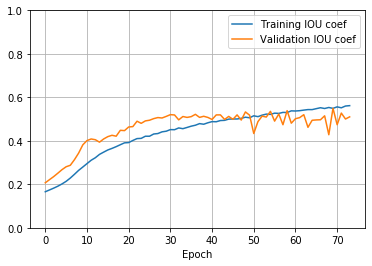

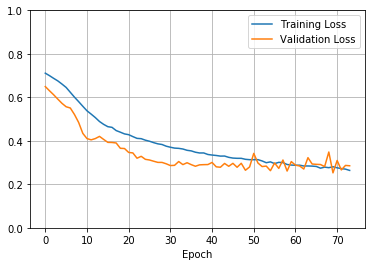

In [33]:
# Show a training report
training_info = pd.read_csv('./Logs/fullyCNN_log.csv', header=0)

acc1, = plt.plot(training_info['epoch'], training_info['iou_coef'])
acc2, = plt.plot(training_info['epoch'], training_info['val_iou_coef'])
plt.legend([acc1, acc2], ['Training IOU coef', 'Validation IOU coef'])
plt.xlabel('Epoch')
plt.ylim(0,1)
plt.grid(True)
plt.show()

loss1, = plt.plot(training_info['epoch'], training_info['loss'])
loss2, = plt.plot(training_info['epoch'], training_info['val_loss'])
plt.legend([acc1, acc2], ['Training Loss', 'Validation Loss'])                            
plt.xlabel('Epoch')
plt.ylim(0,1)
plt.grid(True)

plt.show()

## Model Evaluation

In [15]:
model = load_model("./Models/fullyCNN_temp.h5", custom_objects={'soft_dice_loss': soft_dice_loss, 'iou_coef': iou_coef})
#model.evaluate(test_images, test_label)
predictions = model.predict(test_image, verbose=1)

94/94 [==============================] - 227s 2s/step


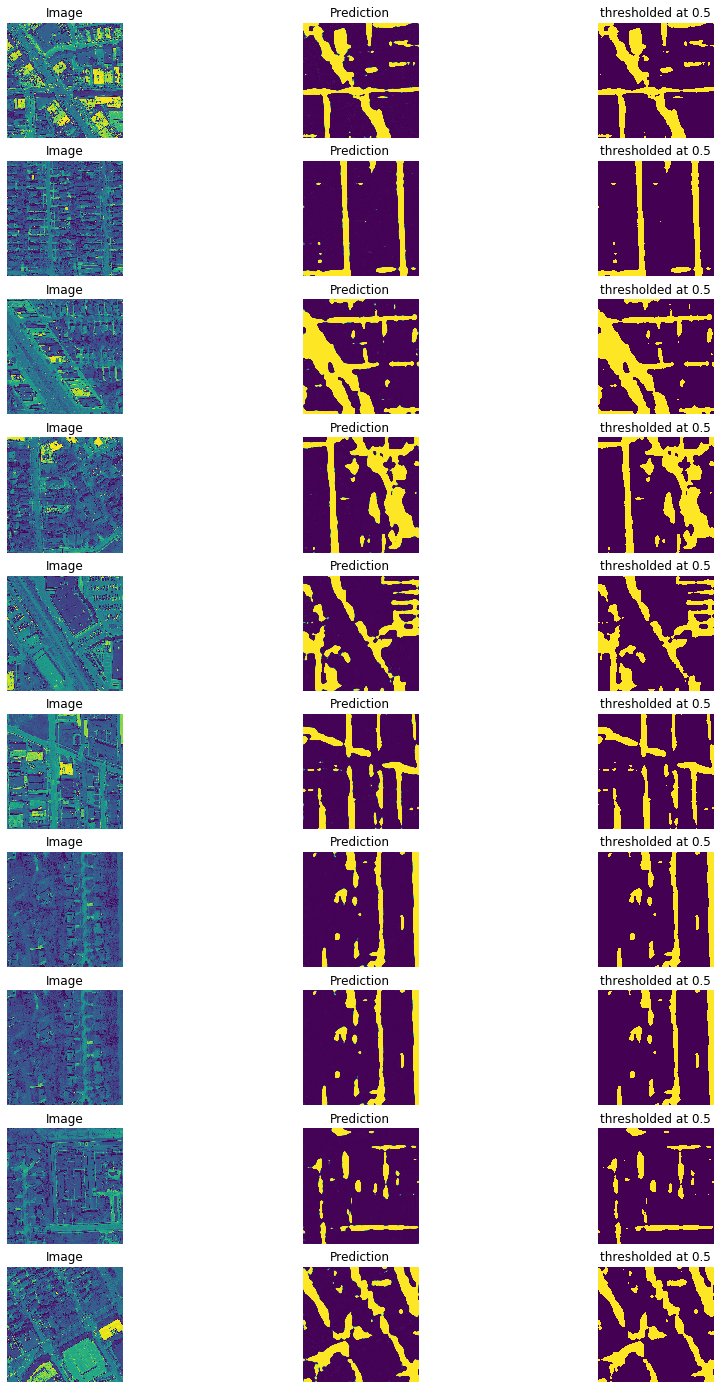

In [20]:
thresh_val = 0.5
predicton_threshold = (predictions > thresh_val).astype(np.uint8)

index = random.randint(0, len(predictions)-1)
num_samples = 10

f = plt.figure(figsize = (15, 25))
for i in range(1, num_samples*3, 3):
  index = random.randint(0, len(predictions)-1)

  f.add_subplot(num_samples, 3, i)
  plt.imshow(test_image[index][:,:,0])
  plt.title("Image")
  plt.axis('off')

  f.add_subplot(num_samples, 3, i+1)
  plt.imshow(np.squeeze(predictions[index][:,:,0]))
  plt.title("Prediction")
  plt.axis('off')

  f.add_subplot(num_samples, 3, i+2)
  plt.imshow(np.squeeze(predicton_threshold[index][:,:,0]))
  plt.title("Thresholded at {}".format(thresh_val))
  plt.axis('off')

plt.show()

## Create Submission File

In [73]:
result_dir = './Results/Prediction_Images/'
[imageio.imwrite(result_dir + files_test[i], predictions[i]) for i in range(n_test)]
files_predictions = os.listdir(result_dir)
files_predictions = [result_dir + files_predictions[i] for i in range(n_test)]
masks_to_submission('./Results/Submissions/fullyCNN_baseline_19_April.csv', *files_predictions)
print('Submission ready')